In [1]:
#This notebook is responsible for parsing and splitting of the recorded eye tracking, EDA and ECG data.
#For PLUX data the workflow is as follows:
#1) The .txt files are read in and then splitted up into each section of the study, by entering sectionnames and according start
#   and end times. Splitted up files are then stored as "NameOfTheSection.csv"
#2) The splitted up files are then parsed and further analysis is done using neurokit.
#   This creates files with statistics, that are stored as "NameOfTheSectionStatistics.csv"
#3) Some columns must be filtered for outliers. We did this using a median filter with a 10% cutoff.
#   So a median filter is applied to the selected column of the dataframe from the "NameOfTheSectionStatistics.csv" file
#   and the result is written into the same "NameOfTheSectionStatistics.csv" file, into a new column called "NameOfTheColumn_MedianFiltered"
#4) Finally, data gets normalized according to Braithwaites Guide for EDA, similarly to the median filtering.
#   For normalization you need all recording i.e. baseline, cooldown, and both runs of the level; these are supplied via paths
#   Then the method runs with the column to be normalized as parameter and writes the normalized data in the "NameOfTheColumn_Normalized"
#   in the respective "NameOfTheSectionStatistics.csv".
#
#
#A comparison file for nearly perfect biosignal data can be loaded via:
#df = pd.read_csv("https://raw.githubusercontent.com/neuropsychology/NeuroKit.py/master/examples/Bio/bio_100Hz.csv")


"""
The general order of execution should be:
1) Insert the path to the raw data and run splicer and fixationSplicer for each raw data recording and enter the sections and timestamps.
    (Potentially, you could also merge splicer and fixationSplicer into one method, 
    however because the fixations do not have a baseline or cooldown, you have to consider how you solve that)
2) Insert the path to the spliced up files in the calculateStatistics method and execute it
3) Insert the path to the statisticsFiles in the outlierDetection_Median method.
    Execute the method with the name of the column that should be filtered as the methods parameter.
    If more then 1 column should be filtered, repeat 3) with the additional columns as parameters.
4) Insert the paths to the statisticsFiles in the baselineNormalization method.
    Execute the method with the name of the column that should be normalized as the methods parameter.
    If more then 1 column should be normalized, repeat 4) with the additional columns as parameters.
5) Proceed with DescriptiveStatistic or Visualizing
"""

In [2]:
import pandas as pd
import datetime
import neurokit as nk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os

In [4]:
# This method receives the name of a section; for example Baseline, Cooldown, Kanal, PS and PS_VS in our case
# and will then prompt you to enter the start and end times for that section in absolute timestamps.
# For example 15:30:42 by asking for hour, minute and second of start and same for end of the section.
# Then it will return a tuple containing the start and end timestamp as a datetime Object to possibly calculate a delta.
def getSectionTimes(sectionName):
    sectionStartHour = int(input('Enter hour for section start of ' + sectionName + ': '))
    sectionStartMinute = int(input('Enter minute for section start of ' + sectionName + ': '))
    sectionStartSecond = int(input('Enter second for section start of ' + sectionName + ': '))
    sectionStart = datetime.time(sectionStartHour, sectionStartMinute, sectionStartSecond)
    sectionStart = datetime.datetime.combine(datetime.date.today(), sectionStart)
    
    sectionEndHour = int(input('Enter hour for section end of ' + sectionName + ': '))
    sectionEndMinute = int(input('Enter minute for section end of ' + sectionName + ': '))
    sectionEndSecond = int(input('Enter second for section end of ' + sectionName + ': '))
    sectionEnd = datetime.time(sectionEndHour, sectionEndMinute, sectionEndSecond)
    sectionEnd = datetime.datetime.combine(datetime.date.today(), sectionEnd)
    times = [sectionStart, sectionEnd]
    return times

In [6]:
# This method prompts the user to enter the timestamp when the file recording started by asking for hour, minute and second
# of the starting timestamp. Then it will return this time as a datetime Object to possibly calculate a delta.
def getFileStartTime():
    fileStartHour = int(input('Enter hour for file start: '))
    fileStartMinute = int(input('Enter minute for file start: '))
    fileStartSecond = int(input('Enter second for file start: '))
    fileStart = datetime.time(fileStartHour, fileStartMinute, fileStartSecond)
    fileStart = datetime.datetime.combine(datetime.date.today(), fileStart)
    return fileStart


In [8]:
# This method prompts the user for the path to the file that should be edited.
# It expects a following format: "D:\Documents\Uni\PdF\P001\Baseline.csv" or "D:\Documents\Uni\PdF\P001\P001.txt"
def getFilePath(text = None):
    if text is None:
        filePath = input("Path to File: ")
    else:    
        filePath = input("Path to the " + text + " - File: ")
    return filePath

In [10]:
#This method is used to read the .txt files that PLUX created
# it uses the "measurment_vars" to store the layout of the cst-file. As the Plux sensors had the following layout
# id, 0, ECG, EDA in our experiment that is, what is set in the measurement_vars. If you have a different layout, you need
# to change the measurement_vars or write another def with the correct vars.
def getDFHandler(filePath):
    measurement_vars = ['id', '0', 'ECG', 'EDA']
    try:
        measurement_df = pd.read_csv(filePath, sep= '\t', header = None, names = measurement_vars)
    except IOError:
            print ("Could not open file, wrong path?")
    return measurement_df

In [11]:
#This method is used to read the .csv files, that are created, after having split the .txt files and having done further analysis
#with the neurokit toolbox
def getDFHandler_StatisticsFile(filePath):
    try:
        measurement_df = pd.read_csv(filePath, index_col = 0)
    except IOError:
        print("Could not open file, wrong path?")
    return measurement_df

In [12]:
#This method is used to read the .csv files that gazepoint Analysis created when exporting the fixations
def getDFHandler_FixationsFile(filePath):
    try:
        measurement_df = pd.read_csv(filePath)
    except IOError:
        print ("Could not open file, wrong path?")
    return measurement_df

In [16]:
# This method will prompt the user to input the section-names, as these will later be used, to create the filenames.
# It returns a list of the sectionNames
# if you are done entering section names, you must type 'end' into the prompt.
def getSections():
    sectionName = ""
    sections = []
    sectionName = input("Enter the first section name please, or type \"end\" to proceed with the splicing: ")
    while (sectionName != "end"):
        sections.append(sectionName)
        sectionName = input("Enter the next section name please, or type \"end\" to proceed with the splicing: ")
    return sections

In [18]:
# This method is used to acess the csv files, that were created after segmentation of the sections.
# It expects a filepath like "D:\Documents\Uni\PdF\P001\Baseline.csv"
def getDFHandler_csv(filePath):
    measurement_vars = ['id', 'ECG', 'EDA']
    try:
        measurement_df = pd.read_csv(filePath, header = 0, names = measurement_vars)
    except IOError:
        print ("Could not open file, something wrong maybe?")
    return measurement_df

C:\Users\Alx-Wo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


We created a DataFrame with the required fixations for each second, now we can start to splice it up
Enter hour for file start: 13
Enter minute for file start: 19
Enter second for file start: 46
Enter the first section name please, or type "end" to proceed with the splicing: PSVS
Enter the next section name please, or type "end" to proceed with the splicing: PS
Enter the next section name please, or type "end" to proceed with the splicing: end
Enter hour for section start of PSVS: 13
Enter minute for section start of PSVS: 32
Enter second for section start of PSVS: 40
Enter hour for section end of PSVS: 13
Enter minute for section end of PSVS: 49
Enter second for section end of PSVS: 30


C:\Users\Alx-Wo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


774
1784
Writing section to csv file to: D:\Dokumente\Uni\Vorlesungen\PdF\Hauptstudie\Data\Hauptstudie_Splitted\H006\Gazepoint\result\PSVS.csv
Enter hour for section start of PS: 13
Enter minute for section start of PS: 50
Enter second for section start of PS: 30
Enter hour for section end of PS: 14
Enter minute for section end of PS: 10
Enter second for section end of PS: 0
1844
3014
Writing section to csv file to: D:\Dokumente\Uni\Vorlesungen\PdF\Hauptstudie\Data\Hauptstudie_Splitted\H006\Gazepoint\result\PS.csv


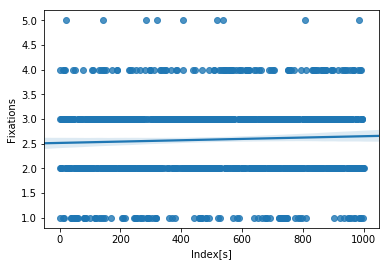

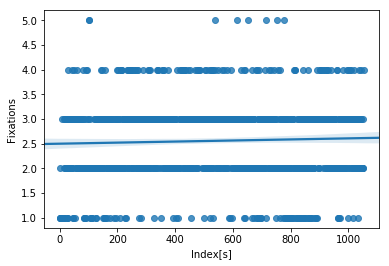

In [23]:
#this method is used, to splice the fixations. Because the fixations file has a different layout than the PLUX files we need separate methods.
def fixationSplicer():
    filePath = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Hauptstudie\\Data\\Hauptstudie_Splitted\\H006\\Gazepoint\\result\\User 0_fixations.csv"
    df = getDFHandler_FixationsFile(filePath)
    #Rename the first column of the fixationsfile from the default name to Time
    df.rename(columns = {list(df)[0]: 'Time'}, inplace = True)
    #Pick only the Time column that gives a Timestamp[s] for each fixation, in relation to the start time of the recording
    out = df[["Time"]]

    #Round the timestamps to seconds so we can later count the entries/fixations for each second.
    out["Time"] = out["Time"].round()

    #Counting the fixations in each second
    out = out["Time"].value_counts(sort=False)
    #Sort the index aka, the second ascending, because value_counts fucks up the order somehow...
    out = out.sort_index()

    #Add names to the columns of the series and create a dataframe from it.
    out = pd.DataFrame({'Seconds':out.index, 'Fixations':out.values})
    print("We created a DataFrame with the required fixations for each second, now we can start to splice it up")
    
    # get startTime of recording from userinput
    fileStart = getFileStartTime()
    
    # get names and number of sections from userinput
    sections = getSections()
    
    sectionTimes = []
    # here we iterate over the list of sectionnames, asking the user to input the start and end times of each section
    # then we cut the dataframe with the start and end times of each section and directly write them into a csv file.
    # The csv file is being written into the same directory as our textfile, and is named according to the name given in the
    # getSections function from the Userinput.
    for i in sections:
        sectionTimes = getSectionTimes(i)
        startIndex = int((sectionTimes[0] - fileStart).total_seconds())
        print(startIndex)
        endIndex = int ((sectionTimes[1] - fileStart).total_seconds())
        print(endIndex)
        section = out[out["Seconds"].between(startIndex, endIndex)]
        section = section.reset_index()
        section = section.drop(columns = "index")
        section = section.reset_index()
        section = section.rename(index = str, columns = {"index":"Index[s]"})
        
        plt.figure()
        sns.regplot(x = section["Index[s]"], y = section["Fixations"], data = section)
        print ("Writing section to csv file to: " + os.path.dirname(filePath) + "\\" + i + ".csv")
        section.to_csv(os.path.dirname(filePath) + "\\" + i + "_Fixations.csv")
        
fixationSplicer()

In [20]:
#Method to split up the plux recordings [.txt] into separate sections representing each level/baseline measurement.
def splicer():
    print ("Lets start to splice this file up! \n")
    # path to the .txt file that the plux hardware gave us
    filePath = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Hauptstudie\\Data\\Hauptstudie_Splitted\\H001\\PLUX\\H001.txt"
    
    # gets a dataframe containing the raw data from the .txt file
    df = getDFHandler(filePath)
    
    # get startTime of recording from userinput
    fileStart = getFileStartTime()
    
    # get names and number of sections from userinput
    sections = getSections()
    
    sectionTimes = []
    
    #Delete first 3 Rows because they contain header information
    df = df.iloc[3:,]
    
    #Remove id column, because this information is now in the index of your dataframe
    df = df.drop(columns="id")
    
    #Remove Null column, because it contains no valuable information
    df = df.drop(columns="0")
    
    # here we iterate over the list of sectionnames, asking the user to input the start and end times of each section
    # then we cut the dataframe with the start and end times of each section and directly write them into a csv file.
    # The csv file is being written into the same directory as our textfile, and is named according to the name given in the
    # getSections function from the Userinput.
    for i in sections:
        sectionTimes = getSectionTimes(i)
        startIndex = int((sectionTimes[0] - fileStart).total_seconds() *1000)
        endIndex = int ((sectionTimes[1] - fileStart).total_seconds() * 1000)
        section = df[startIndex:endIndex]
    
        print ("Writing section to csv file to: " + os.path.dirname(filePath) + "\\" + i + ".csv")
        section.to_csv(os.path.dirname(filePath) + "\\notConverted\\" + i + ".csv")
    print ("D O N E !")
splicer()

Lets start to splice this file up! 



C:\Users\Alx-Wo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2961: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Enter hour for file start: 09
Enter minute for file start: 15
Enter second for file start: 26
Enter the first section name please, or type "end" to proceed with the splicing: Baseline
Enter the next section name please, or type "end" to proceed with the splicing: Kanal
Enter the next section name please, or type "end" to proceed with the splicing: PS_VS
Enter the next section name please, or type "end" to proceed with the splicing: PS
Enter the next section name please, or type "end" to proceed with the splicing: Cooldown
Enter the next section name please, or type "end" to proceed with the splicing: end
Enter hour for section start of Baseline: 09
Enter minute for section start of Baseline: 16
Enter second for section start of Baseline: 30
Enter hour for section end of Baseline: 09
Enter minute for section end of Baseline: 19
Enter second for section end of Baseline: 30
Writing section to csv file to: D:\Dokumente\Uni\Vorlesungen\PdF\Hauptstudie\Data\Hauptstudie_Splitted\H001\PLUX\Bas

In [ ]:
"""
# DEPRECATED! BETTER USE THE ONE BELOW!
# This method is used to normalize the data in each section.
# Normalization is implemented according to Dawson et al. 
# (SCL - SCLmin) / (SCLmax - SCLmin), whereas SCLmin is the smallest value that was found in our baseline or cooldown
# and SCLmax is the biggest value in all recordings of that participant.
# We expect the user to give us the paths to the Baseline and to all sections. Optionally you can enter the path to the 
# cooldown file or type 'end' if you have no Cooldown file.
# We expect the paths to the raw EDA data for each section. For example the path to the /Baseline.csv or /Minerva.csv only
# contains the columns 'EDA' and 'ECG' which are the raw signals that our plux sensors gave us.
# Then we calculate the Tonic Signal for the EDA for each file and normalize every section.
# The normalized Tonic Signal is then written into hardcoded fileNames for Antibuerger, Minerva, etc.
def normalize(SCLmin, SCLmax, SCL):
    return ((SCL - SCLmin) / (SCLmax - SCLmin))

def baselineNormalization_EDA_Tonic():
    print("Lets normalize our statistic sections")
    #Get Filepaths
    filePathToFolder = getFilePath("C:\\...\\H001\\PLUX") #Enter the full path into the folder where all the parsed .csv are.
    
    filePathToBaseline = filePathToFolder + "\\BaselineStatistics.csv"
    filePathToCooldown = filePathToFolder + "\\CooldownStatistics.csv"
    filePathToAntibuerger = filePathToFolder + "\\Antibuerger1Statistics.csv"
    filePathToMinerva = filePathToFolder + "\\MinervaStatistics.csv"
    filePathToPowerstation = filePathToFolder + "\\Powerstation17Statistics.csv"
    
    
    #SCL for Baseline
    print ("Getting statistics for Baseline")
    baseline = getDFHandler_StatisticsFile(filePathToBaseline)
    baselineTonicMin = baseline["EDA_Tonic"].min()
    baselineTonicMax = baseline["EDA_Tonic"].max()
    cooldownTonicMin = 999999
    
    #SCL for Cooldown
    if (filePathToCooldown != "end"):
        print ("Getting statistics for Cooldown")
        cooldown = getDFHandler_StatisticsFile(filePathToCooldown)
        cooldownTonicMin = cooldown["EDA_Tonic"].min()
        cooldownTonicMax = cooldown["EDA_Tonic"].max()
    
    #SCL for Antibuerger
    print ("Getting statistics for Antibuerger1")
    Antibuerger1 = getDFHandler_StatisticsFile(filePathToAntibuerger)
    Antibuerger1TonicMax = Antibuerger1["EDA_Tonic"].max()
    
    #SCL for Minerva
    print ("Getting statistics for Minerva")
    Minerva = getDFHandler_StatisticsFile(filePathToMinerva)
    MinervaTonicMax = Minerva["EDA_Tonic"].max()
    
    #SCL for Powerstation17
    print ("Getting statistics for Powerstation17")
    Powerstation17 = getDFHandler_StatisticsFile(filePathToPowerstation)
    Powerstation17TonicMax = Powerstation17["EDA_Tonic"].max()
    
    #SCLmin and SCLmax
    SCLmin = min(baselineTonicMin, cooldownTonicMin)
    SCLmax = max(baselineTonicMax, cooldownTonicMax, Antibuerger1TonicMax, MinervaTonicMax, Powerstation17TonicMax)
    print ("SCLmin: " + str(SCLmin))
    print ("SCLmax: " + str(SCLmax))
    
    #Normalizing every section and write to csv
    print ("Writing to BaselineStatistics_Normalized.csv")
    baseline["EDA_Tonic_Normalized"] = baseline["EDA_Tonic"].apply(lambda x: normalize(SCLmin, SCLmax, x))
    baseline.to_csv(os.path.dirname(filePathToBaseline) + "\\BaselineStatistics_Normalized.csv")
    
    print ("Writing to CooldownStatistics_Normalized.csv")
    cooldown["EDA_Tonic_Normalized"] = cooldown["EDA_Tonic"].apply(lambda x: normalize(SCLmin, SCLmax, x))
    cooldown.to_csv(os.path.dirname(filePathToCooldown) + "\\CooldownStatistics_Normalized.csv")
    
    print ("Writing to Antibuerger1Statistics_Normalized.csv")
    Antibuerger1["EDA_Tonic_Normalized"] = Antibuerger1["EDA_Tonic"].apply(lambda x: normalize(SCLmin, SCLmax, x))
    Antibuerger1.to_csv(os.path.dirname(filePathToAntibuerger) + "\\Antibuerger1Statistics_Normalized.csv")
    
    print ("Writing to MinervaStatistics_Normalized.csv")
    Minerva["EDA_Tonic_Normalized"] = Minerva["EDA_Tonic"].apply(lambda x: normalize(SCLmin, SCLmax, x))
    Minerva.to_csv(os.path.dirname(filePathToMinerva) + "\\MinervaStatistics_Normalized.csv")
    
    print ("Writing to Powerstation17Statistics_Normalized.csv")
    Powerstation17["EDA_Tonic_Normalized"] = Powerstation17["EDA_Tonic"].apply(lambda x: normalize(SCLmin, SCLmax, x))
    Powerstation17.to_csv(os.path.dirname(filePathToPowerstation) + "\\Powerstation17Statistics_Normalized.csv")
    
baselineNormalization_EDA_Tonic()
"""

In [23]:
# This method takes the column argument, normalizes the values in there with the baseline values and writes into a new column:
# "column_Normalized" according to Dawson et al.

def normalize(SCLmin, SCLmax, SCL):
    return ((SCL - SCLmin) / (SCLmax - SCLmin))

#This method is called baselineNormalization because it uses a baselinemeasurement to normalize data. It normalized anything you feed it though ;)
def baselineNormalization(column):
    lead = "H0"
    i = 1
    numOfParticipants = 23
    skipParticipants = [3, 5, 15, 23]
    while i <= numOfParticipants: 
        participant = lead + str(i).zfill(2)
        if not (i in skipParticipants):
            #do stuff
            print ("calculate normalization for participant " + participant)
            BASELINEPATH = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Hauptstudie\\Data\\Hauptstudie_Splitted\\" + participant + "\\PLUX\\BaselineStatistics.csv"
            COOLDOWNPATH = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Hauptstudie\\Data\\Hauptstudie_Splitted\\" + participant + "\\PLUX\\CooldownStatistics.csv"
            PSPATH = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Hauptstudie\\Data\\Hauptstudie_Splitted\\" + participant + "\\PLUX\\PSStatistics.csv"
            PSVSPATH = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Hauptstudie\\Data\\Hauptstudie_Splitted\\" + participant + "\\PLUX\\PS_VSStatistics.csv"
            
            
            print("Lets normalize our statistic sections")
        
            print ("Getting statistics for Baseline")
            baseline = getDFHandler_StatisticsFile(BASELINEPATH)
            baselineTonicMin = baseline[column].min()
            baselineTonicMax = baseline[column].max()
            cooldownTonicMin = 999999
    
        
        
            print ("Getting statistics for Cooldown")
            cooldown = getDFHandler_StatisticsFile(COOLDOWNPATH)
            cooldownTonicMin = cooldown[column].min()
            cooldownTonicMax = cooldown[column].max()
    
        
            print ("Getting statistics for PS")
            PS = getDFHandler_StatisticsFile(PSPATH)
            PSTonicMax = PS[column].max()
        
        
            print ("Getting statistics for PSVS")
            PSVS = getDFHandler_StatisticsFile(PSVSPATH)
            PSVSTonicMax = PSVS[column].max()
    
            #SCLmin and SCLmax
            SCLmin = min(baselineTonicMin, cooldownTonicMin)
            SCLmax = max(baselineTonicMax, cooldownTonicMax, PSTonicMax, PSVSTonicMax)
            print (column + "min: " + str(SCLmin))
            print (column + "max: " + str(SCLmax))
    
            targetcolumn = column + "_Normalized"
    
            #Normalizing every section and write to csv
            print ("Writing to BaselineStatistics_Normalized.csv")
            baseline[targetcolumn] = baseline[column].apply(lambda x: normalize(SCLmin, SCLmax, x))
            baseline.to_csv(BASELINEPATH)
    
            print ("Writing to CooldownStatistics_Normalized.csv")
            cooldown[targetcolumn] = cooldown[column].apply(lambda x: normalize(SCLmin, SCLmax, x))
            cooldown.to_csv(COOLDOWNPATH)
    
            print ("Writing to PSStatistics_Normalized.csv")
            PS[targetcolumn] = PS[column].apply(lambda x: normalize(SCLmin, SCLmax, x))
            PS.to_csv(PSPATH)
    
            print ("Writing to PSVSStatistics_Normalized.csv")
            PSVS[targetcolumn] = PSVS[column].apply(lambda x: normalize(SCLmin, SCLmax, x))
            PSVS.to_csv(PSVSPATH)
    
            
        else:
            #skip participant
            print ("skipping participant " + participant)
        i += 1
        
baselineNormalization("Heart_Rate_MedianFiltered")

skipping participant H001
skipping participant H002
calculate normalization for participant H003
Lets normalize our statistic sections
Getting statistics for Baseline
Getting statistics for Cooldown
Getting statistics for PS


C:\Users\Alx-Wo\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Getting statistics for PSVS
Heart_Rate_MedianFilteredmin: 72.45605030849042
Heart_Rate_MedianFilteredmax: 94.4423631978908
Writing to BaselineStatistics_Normalized.csv
Writing to CooldownStatistics_Normalized.csv
Writing to PSStatistics_Normalized.csv
Writing to PSVSStatistics_Normalized.csv
skipping participant H004
skipping participant H005
skipping participant H006
skipping participant H007
skipping participant H008
skipping participant H009
calculate normalization for participant H010
Lets normalize our statistic sections
Getting statistics for Baseline
Getting statistics for Cooldown
Getting statistics for PS
Getting statistics for PSVS
Heart_Rate_MedianFilteredmin: 79.27606045385082
Heart_Rate_MedianFilteredmax: 110.26040422582693
Writing to BaselineStatistics_Normalized.csv
Writing to CooldownStatistics_Normalized.csv
Writing to PSStatistics_Normalized.csv
Writing to PSVSStatistics_Normalized.csv
calculate normalization for participant H011
Lets normalize our statistic sections


In [20]:
#Currently we only calculate the statistical things with neurokit for the EDA data, because ECG data was erroneous and lead
#to crashes. If you also want to calculate the parameters for the ECG data, use the commented function call for:
#nk.bio_prcoess(ecg = baseline["ECG"], eda = baseline["EDA"], sampling_rate = 1000) for all 4 sections respectively.
def calculateStatistics():
    print("We will calculate all required statistics now and write it in 1 .csv file for each section")
    lead = "H0"
    i = 1
    numOfParticipants = 23
    skipParticipants = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19 , 20, 21, 22]
    while i <= numOfParticipants:
        #making adding 0i or i, if i has 2 digits to H0 making H001, H002, ..., H10, H11, ..., H0numOfParticipants
        participant = lead + str(i).zfill(2)
        if not (i in skipParticipants):
            #do stuff
            BASELINEPATH = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Hauptstudie\\Data\\Hauptstudie_Splitted\\" + participant + "\\PLUX\\Baseline.csv"
            COOLDOWNPATH = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Hauptstudie\\Data\\Hauptstudie_Splitted\\" + participant + "\\PLUX\\Cooldown.csv"
            PSPATH = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Hauptstudie\\Data\\Hauptstudie_Splitted\\" + participant + "\\PLUX\\PS.csv"
            PSVSPATH = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Hauptstudie\\Data\\Hauptstudie_Splitted\\" + participant + "\\PLUX\\PS_VS.csv"
            print ("Calculating statistics for participant: " + participant)
            #Baseline
            baseline = getDFHandler_csv(BASELINEPATH)
            print ("Calculating statistics for Baseline")
            #baselineAllStat = nk.bio_process(ecg = baseline["ECG"], eda = baseline["EDA"], sampling_rate = 1000)
            baselineAllStat = nk.bio_process(eda = baseline["EDA"], sampling_rate = 1000)
            df_baseline = pd.DataFrame(baselineAllStat["df"])
            df_baseline.to_csv(os.path.dirname(BASELINEPATH) + os.path.basename(os.path.normpath(BASELINEPATH).split('.')[0]) + "Statistics.csv")
            #The path used to be hardcoded for debug reasons, the upper version just writes to the same path as the original file
            #but adds Statistics to the name --> BaselineStatistics.csv
            #df_baseline.to_csv(os.path.dirname(BASELINEPATH) + "\\" + "BaselineStatistics_EDAOnly" + ".csv")
            #Cooldown
            cooldown = getDFHandler_csv(COOLDOWNPATH)
            print ("Calculating statistics for Cooldown")
            #cooldownAllStat = nk.bio_process(ecg = cooldown["ECG"], eda = cooldown["EDA"], sampling_rate = 1000)
            cooldownAllStat = nk.bio_process(eda = cooldown["EDA"], sampling_rate = 1000)
            df_cooldown = pd.DataFrame(cooldownAllStat["df"])
            #df_cooldown.to_csv(os.path.dirname(COOLDOWNPATH) + "\\" + "CooldownStatistics_EDAOnly" + ".csv")
            df_cooldown.to_csv(os.path.dirname(BASELINEPATH) + os.path.basename(os.path.normpath(BASELINEPATH).split('.')[0]) + "Statistics.csv")
            #PS
            ps = getDFHandler_csv(PSPATH)
            print ("Calculating statistics for PS")
            #psAllStat = nk.bio_process(ecg = ps["ECG"], eda = ps["EDA"], sampling_rate = 1000)
            psAllStat = nk.bio_process(eda = ps["EDA"], sampling_rate = 1000)
            df_ps = pd.DataFrame(psAllStat["df"])
            #df_ps.to_csv(os.path.dirname(PSPATH) + "\\" + "PSStatistics_EDAOnly" + ".csv")
            df_ps.to_csv(os.path.dirname(PSPATH) + os.path.basename(os.path.normpath(PSPATH).split('.')[0]) + "Statistics.csv")
            #PS+VS
            psvs = getDFHandler_csv(PSVSPATH)
            print ("Calculating statistics for PS+VS")
            #psvsAllStat = nk.bio_process(ecg = psvs["ECG"], eda = psvs["EDA"], sampling_rate = 1000)
            psvsAllStat = nk.bio_process(eda = psvs["EDA"], sampling_rate = 1000)
            df_psvs = pd.DataFrame(psvsAllStat["df"])
            #df_psvs.to_csv(os.path.dirname(PSVSPATH) + "\\" + "PS_VSStatistics_EDAOnly" + ".csv")
            df_psvs.to_csv(os.path.dirname(PSVSPATH) + os.path.basename(os.path.normpath(PSVSPATH).split('.')[0]) + "Statistics.csv")
            
        else:
            #skip participant
            print ("Skipping participant " + participant)
            
        i += 1
    
calculateStatistics()
    

We will calculate all required statistics now and write it in 1 .csv file for each section
Skipping participant H001
Skipping participant H002
Skipping participant H003
Skipping participant H004
Skipping participant H005
Skipping participant H006
Skipping participant H007
Skipping participant H008
Skipping participant H009
Skipping participant H010
Skipping participant H011
Skipping participant H012
Skipping participant H013
Skipping participant H014
Skipping participant H015
Skipping participant H016
Skipping participant H017
Skipping participant H018
Skipping participant H019
Skipping participant H020
Skipping participant H021
Skipping participant H022
Calculating statistics for participant: H023
Calculating statistics for Baseline


C:\Users\Alx-Wo\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Calculating statistics for Cooldown
Calculating statistics for PS
Calculating statistics for PS+VS


In [22]:
#This method applies the medianfilter to the selected column and adds the result to a new column called
# "columnName_MedianFiltered" to the same .csv file
def outlierDetection_Median(column):
    lead = "H0"
    i = 1
    numOfParticipants = 23
    #The numbers of the participants, that should be skipped --> skipping H004 and H006 in this case
    skipParticipants = [4, 6]
    #Looping over the number of participants. 
    #This is used to iterate into each folder of the data; assuming, the folder structure was created accordingly.
    while i <= numOfParticipants: 
        #Creating the participant string to add into the paths from the while-loop-integer
        #--> i = 10 --> participant = H010 | i = 5 --> participant = H005 etc.
        #This will work for numbers up to 99. If we ever have more than 99 participants, this will break...
        participant = lead + str(i).zfill(2)
        if not (i in skipParticipants):
            #do stuff
            print ("calculate medianfilter for participant " + participant)
            
            BASELINEPATH = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Hauptstudie\\Data\\Hauptstudie_Splitted\\" + participant + "\\PLUX\\BaselineStatistics.csv"
            COOLDOWNPATH = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Hauptstudie\\Data\\Hauptstudie_Splitted\\" + participant + "\\PLUX\\CooldownStatistics.csv"
            PSPATH = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Hauptstudie\\Data\\Hauptstudie_Splitted\\" + participant + "\\PLUX\\PSStatistics.csv"
            PSVSPATH = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Hauptstudie\\Data\\Hauptstudie_Splitted\\" + participant + "\\PLUX\\PS_VSStatistics.csv"
            
            #instancing the dataframes from the .csv path
            baseline = getDFHandler_StatisticsFile(BASELINEPATH)
    
            cooldown = getDFHandler_StatisticsFile(COOLDOWNPATH)
        
            PS = getDFHandler_StatisticsFile(PSPATH)

            PSVS = getDFHandler_StatisticsFile(PSVSPATH)

    
            targetColumn = column + "_MedianFiltered"
    
            median = baseline[column].median()
            minThreshold = median - (median * 0.1)
            maxThreshold = median + (median * 0.1)
            filtered = baseline.loc[(baseline[column] > minThreshold) & (baseline[column] < maxThreshold)]
            baseline[targetColumn] = filtered[column]
            baseline.to_csv(BASELINEPATH)
    
            median = cooldown[column].median()
            minThreshold = median - (median * 0.1)
            maxThreshold = median + (median * 0.1)
            filtered = cooldown.loc[(cooldown[column] > minThreshold) & (cooldown[column] < maxThreshold)]
            cooldown[targetColumn] = filtered[column]
            cooldown.to_csv(COOLDOWNPATH)
    
            median = PS[column].median()
            minThreshold = median - (median * 0.1)
            maxThreshold = median + (median * 0.1)
            filtered = PS.loc[(PS[column] > minThreshold) & (PS[column] < maxThreshold)]
            PS[targetColumn] = filtered[column]
            PS.to_csv(PSPATH)
    
            median = PSVS[column].median()
            minThreshold = median - (median * 0.1)
            maxThreshold = median + (median * 0.1)
            filtered = PSVS.loc[(PSVS[column] > minThreshold) & (PSVS[column] < maxThreshold)]
            PSVS[targetColumn] = filtered[column]
            PSVS.to_csv(PSVSPATH)
    
        else:
            #skip participant
            print ("skipping participant " + participant)
        i += 1

#Executing this function with the parameter Heart_Rate 
#--> Takes all values in Heart_Rate, applies the medianfilter and writes the results in Heart_Rate_MedianFiltered
outlierDetection_Median("Heart_Rate")

skipping participant H001
skipping participant H002
calculate medianfilter for participant H003


C:\Users\Alx-Wo\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


skipping participant H004
skipping participant H005
skipping participant H006
skipping participant H007
skipping participant H008
skipping participant H009
calculate medianfilter for participant H010
calculate medianfilter for participant H011
calculate medianfilter for participant H012
skipping participant H013
calculate medianfilter for participant H014
calculate medianfilter for participant H015
skipping participant H016
calculate medianfilter for participant H017
skipping participant H018
skipping participant H019
skipping participant H020
skipping participant H021
calculate medianfilter for participant H022
calculate medianfilter for participant H023


In [ ]:
#This method was used to test another implementation of outlier detection but was not used in the final evaluation
def outlierDetection_SDev(column):
    #filePath = getFilePath("Statistics")
    columnName = column + "outlierRemoved"
    filePath = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Probanden\\P002\\PLUX\\Powerstation17Statistics_Normalized.csv"
    df = getDFHandler_StatisticsFile(filePath)
    df_out = df[np.abs(df[column]-df[column].mean()) <= (3*df[column].std())]
    #print (df_out)
    asdf = sns.relplot(x = "index", y = column, data = df_out.reset_index())
    asdf2 = sns.relplot(x = "index", y = column, data = df.reset_index())
    asdf.savefig("D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Probanden\\P002\\PLUX\\PowerstationEDA_Normalized_SDevOutliers.png")
outlierDetection_SDev("EDA_Tonic_Normalized")

In [ ]:
#This method was used to test another implementation of outlier detection but was not used in the final evaluation
def outlierDetection_RollingMedian(column):
    filePath = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Probanden\\P004\\PLUX\\Powerstation17Statistics_Normalized.csv"
    df = getDFHandler_StatisticsFile(filePath)
    df_out = pd.DataFrame()
    df_out['median']= df[column].rolling(window=1000).median()
    df_out['std'] = df[column].rolling(1000).std()
    asdf = sns.relplot(x = "index", y = column, data = df.reset_index())
    asdf1 = sns.relplot(x = "index", y = 'median', data = df_out.reset_index())
    return
    #filter setup
    df_out = df[(df[column] <= df_out['median']+3*df_out['std']) & (df[column] >= df_out['median']-3*df_out['std'])]
    asdf = sns.relplot(x = "index", y = column, data = df_out.reset_index())
    asdf.savefig("D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Probanden\\P002\\PLUX\\PowerstationEDA_Normalized_RollingSDevOutliers.png")
    asdf2 = sns.relplot(x = "index", y = column, data = df.reset_index())
    
outlierDetection_RollingMedian("EDA_Raw")

In [ ]:
def logTransformation(column):
    filePath = "D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Probanden\\P004\\PLUX\\Powerstation17Statistics_Normalized.csv"
    df = getDFHandler_StatisticsFile(filePath)
    df["logEDA"] = np.log(df[column])
    #print (df["logEDA"])
    #print (df[column])
    asdf = sns.relplot(x = "index", y = "logEDA", data = df.reset_index())
    #asdf.savefig("D:\\Dokumente\\Uni\\Vorlesungen\\PdF\\Probanden\\P002\\PLUX\\PowerstationEDA_Normalized_LogTrafOutliers.png")
    asdf2 = sns.relplot(x = "index", y = column, data = df.reset_index())
logTransformation("EDA_Filtered")
    